In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
import argparse
import os
import rasterio
import sys
from tqdm import tqdm 

In [2]:
from scripts.model import *
from scripts.utils import jaccard_index_prob, jaccard_loss, mcc, f1_score, overall_accuracy
from scripts.utils import TIFDataset, ToTensor

In [3]:
# Set variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'output/models/model_42827545_bs8_lr0.0002_epochs100_bands5_jaccard_loss.pth'
val_set_path = '/Users/bgl/Ensta/3a/pfe/data/validation-2015-2'

# Load model
model = UNet(n_channels=5, n_classes=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [4]:
# Load data. Dataloader ?
bands3 = ['B2', 'B3', 'B4']
bands5 = ['B2', 'B3', 'B4', 'B8', 'ndvi']
bands9 = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ndvi']
bands16 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'ndvi', 'elev', 'slope']
bands = bands5
val_dataset = TIFDataset(val_set_path, transform=ToTensor(), selected_bands=bands)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print('Validation set loaded.')

Validation set loaded.


In [21]:
# Evaluate model
model.eval()
jaccard_index = 0
mcc_score = 0
f1 = 0
oa = 0

nan_count = 0
with torch.no_grad():
    for i, data in enumerate(valloader):
        print('Name :', data['name'])
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        
        #print(jaccard_index_prob(outputs, labels))
        
        # Check if labels is not NaN
        if torch.isnan(labels).any():
            print('Labels contains NaN')
            print(data['name'])
            nan_count += 1
            print("NaN count : ", nan_count)
            pass
            
        if torch.isnan(inputs).any():
            print('Inputs contains NaN')
            print(data['name'])
            nan_count += 1
            print("NaN count : ", nan_count)
            pass
            
        outputs = model(inputs)
        #outputs = torch.sigmoid(outputs)
        j = jaccard_index_prob(outputs, labels)
        # if j is not NaN
        if not torch.isnan(j):
            print('Jaccard index :', j.item())
            jaccard_index += j
        else :
            print('Jaccard index is NaN')
        print(jaccard_index)
        mcc_score += mcc(outputs, labels)
        f1 += f1_score(outputs, labels)
        oa += overall_accuracy(outputs, labels)
        print(f'Image {i+1} done.')


l = len(valloader) - nan_count
print('Len valloader :', l)
jaccard_index /= l
mcc_score /= l
f1 /= l
oa /= l
print(f'Jaccard index: {jaccard_index}')
print(f'MCC: {mcc_score}')
print(f'F1 score: {f1}')
print(f'Overall accuracy: {oa}')



Name : ['img9498.tif']
Jaccard index : 0.3299998342990875
tensor(0.3300)
Image 1 done.
Name : ['img8792.tif']
Jaccard index : 0.31476664543151855
tensor(0.6448)
Image 2 done.
Name : ['img4180.tif']
Jaccard index : 0.2965972125530243
tensor(0.9414)
Image 3 done.
Name : ['img5507.tif']
Jaccard index : 0.028964579105377197
tensor(0.9703)
Image 4 done.
Name : ['img8023.tif']
Jaccard index : 0.19263902306556702
tensor(1.1630)
Image 5 done.
Name : ['img8745.tif']
Jaccard index : 0.324433833360672
tensor(1.4874)
Image 6 done.
Name : ['img1013.tif']
Jaccard index : 0.2947023808956146
tensor(1.7821)
Image 7 done.
Name : ['img7462.tif']
Jaccard index : 0.1712789535522461
tensor(1.9534)
Image 8 done.
Name : ['img8037.tif']
Jaccard index : 0.18635718524456024
tensor(2.1397)
Image 9 done.
Name : ['img3162.tif']
Jaccard index : 0.11250587552785873
tensor(2.2522)
Image 10 done.
Name : ['img4143.tif']
Jaccard index : 0.08792872726917267
tensor(2.3402)
Image 11 done.
Name : ['img2240.tif']
Jaccard inde

In [6]:
# TODO : count the number of images with no hedgerow label
counter = 0
for i, data in enumerate(valloader):
    labels = data['label']
    if labels.sum() == 0:
        counter += 1
print(f'Number of images with no hedgerow label: {counter}')


Number of images with no hedgerow label: 543


In [5]:
# Visualize results
def try_model(model, img_path, eval_metric, selected_bands):
    """
    Display one test image, the corresponding ground truth, and the model prediction
    """
    with rasterio.open(img_path) as src:
        # Read the image data
        raster = src.read()
        # Read the image metadata
        band_names = src.descriptions

    # Extract input channels
    indices = [band_names.index(band) for band in selected_bands]
    image = raster[indices, :, :].astype(np.float32)
    label = raster[-1, :, :].astype(np.float32)

    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0).to(device)

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        score = eval_metric(output, label_tensor).item()
        print('Score (Jaccard index) :', score)

    # Post-process the output (e.g., thresholding)
    threshold = 0.3
    output_thresh = (torch.sigmoid(output) > threshold).float()

    # Convert output to numpy array for visualization
    output_thresh_np = output_thresh.squeeze().cpu().numpy()
    output_np = output.squeeze().cpu().numpy()

    # Build an image with TP, TF, FP, FN
    # Initialize an RGB image with the same height and width, and 3 channels for RGB
    results = np.zeros((256, 256, 3), dtype=np.uint8)

    # Define the colors
    color_tp = [200, 255, 200]  # Green for true positives
    color_fn = [0, 0, 255]  # Blue for false negatives
    color_fp = [255, 0, 0]  # Red for false positives
    color_tn = [0, 0, 0]  # Black for true negatives

    # Create the image
    for i in range(256):
        for j in range(256):
            if output_thresh_np[i, j] == 1 and label[i, j] == 1:
                results[i, j] = color_tp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 1:
                results[i, j] = color_fn
            elif output_thresh_np[i, j] == 1 and label[i, j] == 0:
                results[i, j] = color_fp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 0:
                results[i, j] = color_tn


    # Get RGB composite
    rgb_indices = [band_names.index(band) for band in ['B4', 'B3', 'B2']]
    rgb = raster[rgb_indices, :, :].astype(np.float32)
    
    def adjust_gamma_band(image_band, gamma):
        # Apply gamma correction (non-linear transformation) for a single band
        return np.power(image_band, gamma)
    
    rgb_gamma = np.stack([adjust_gamma_band(rgb[:,:,0], 1.3), rgb[:,:,1], rgb[:,:,2]], axis=2)

    mx = 0.3 #np.max(rgb)
    rgb = (rgb) / (mx)

    # Display input RGB image, labels, and predictions
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(rgb.transpose(1, 2, 0))
    axs[0, 0].set_title('Input Image')
    axs[1, 0].imshow(label, cmap='gray')
    axs[1, 0].set_title('Ground Truth')
    axs[1, 1].imshow(output_thresh_np, cmap='gray')
    axs[1, 1].set_title('Prediction')
    axs[0, 1].imshow(results)
    axs[0, 1].set_title('Confusion Matrix')
    plt.show()
    plt.close(fig)

Score (Jaccard index) : 0.13308656215667725


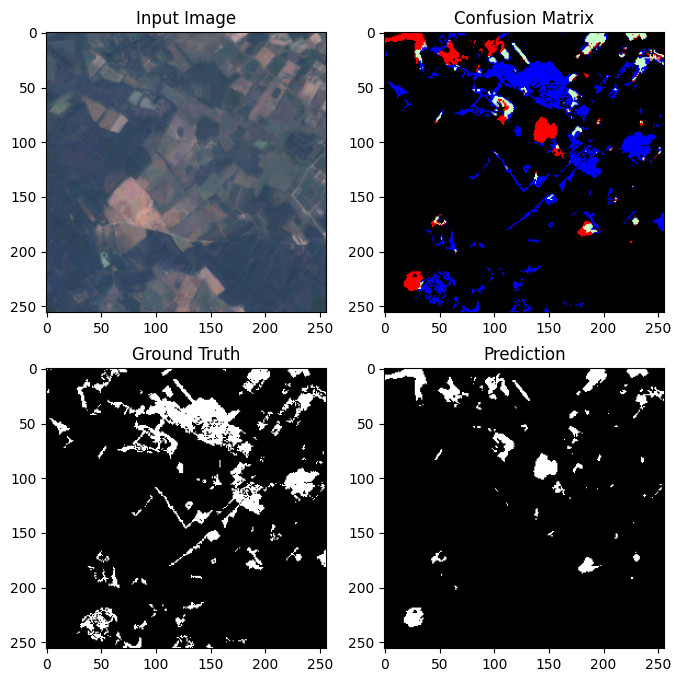

In [26]:
img_path = '/Users/bgl/Ensta/3a/pfe/data/validation-2015-2/img7169.tif'

try_model(model, img_path, jaccard_index_prob, bands5)